# Time series forecasting

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">[weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 1s 0us/step


In [3]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [9]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [8]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series
First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [23]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13faffd10>],
      dtype=object)

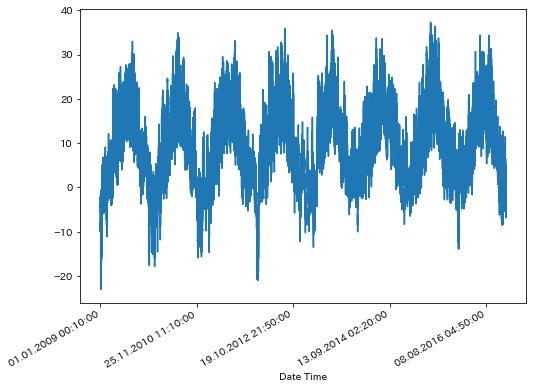

In [24]:
uni_data.plot(subplots=True)

In [25]:
uni_data = uni_data.values

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].

Note: The mean and standard deviation should only be computed using the training data.

In [26]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data.

In [27]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [28]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [29]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [30]:
def create_time_steps(length):
    return list(range(-length, 0))

In [31]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/Users/macico/.pyenv/versions/3.7.6/envs/py37b/lib/python3.7/site-packages/matplotlib/pyplot.py'>

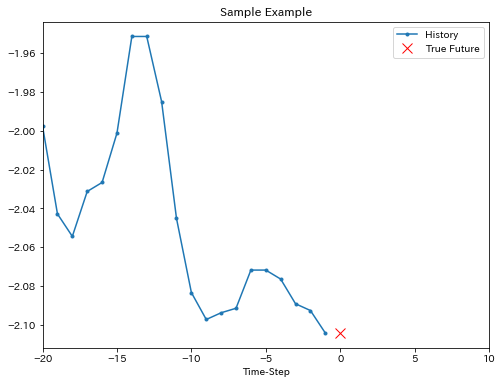

In [32]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [33]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/home/kbuilder/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

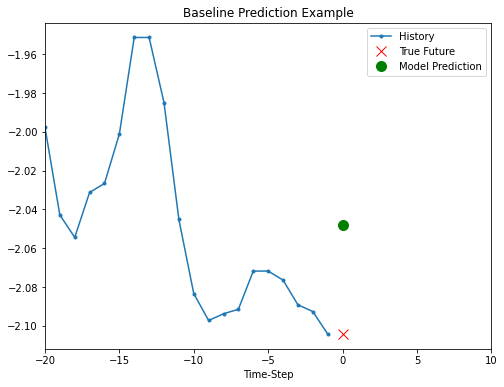

In [20]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [34]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000#windowsize

#dataset 化
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
# シャッフルバッファのサイズをデータセットとおなじに設定することで、データが完全にシャッフルされる
# よくシャッフルされ
# バッチ化され
# 限りなく繰り返され
# バッチが出来るだけ早く利用できる
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [39]:
len(x_train_uni)

299980

The following visualisation should help you understand how the data is represented after batching.

![Time Series](images/time_series.png)

You will see the LSTM requires the input shape of the data it is being given.

In [44]:
x_train_uni.shape

(299980, 20, 1)

In [45]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8,
                         input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [49]:
#get 1 batch
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [42]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate,
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 5s 26ms/step - loss: 0.8283 - val_loss: 0.2655
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2484 - val_loss: 0.0646
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0769 - val_loss: 0.0310
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0501 - val_loss: 0.0251
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0305 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0318 - val_loss: 0.0219
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0289 - val_loss: 0.0208
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0268 - val_loss: 0.0199
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0260 - val_loss: 0.0191
Epoch 10/10
200/200 [===========================

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

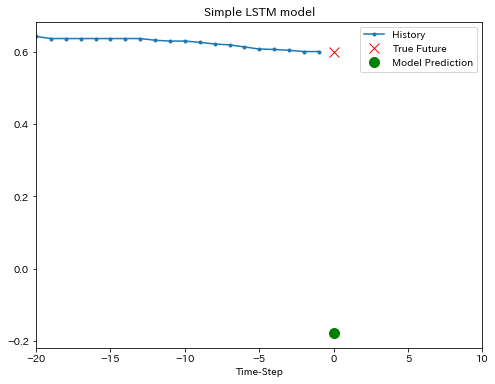

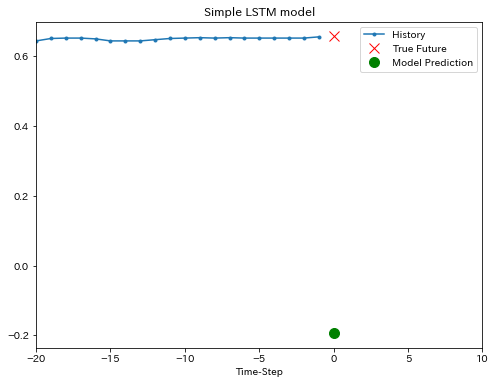

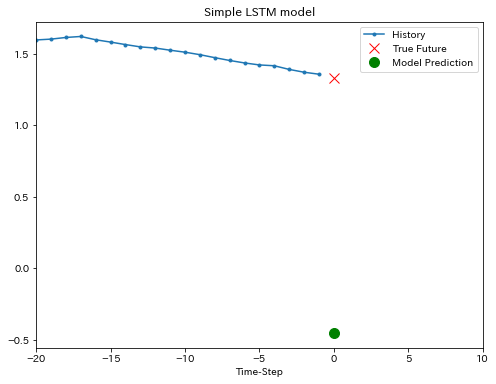

In [47]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),simple_lstm_model.predict(x)[0]],
                     0,
                     'Simple LSTM model')
    plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [50]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [51]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13d4c04d0>,
      dtype=object)

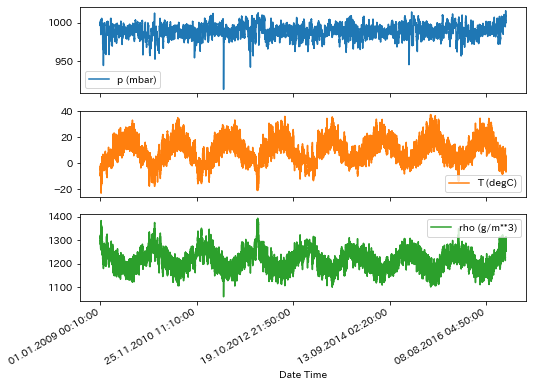

In [52]:
features.plot(subplots=True)

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [94]:
dataset.shape

(420551, 3)

In [53]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [54]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [57]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour(6times*24h*5days). The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [59]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset,
                                                   dataset[:, 1],
                                                   0,
                                                   TRAIN_SPLIT,
                                                   past_history,
                                                   future_target, 
                                                   STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset,
                                               dataset[:, 1],
                                               TRAIN_SPLIT,
                                               None, 
                                               past_history,
                                               future_target,
                                               STEP,
                                               single_step=True)

In [63]:
x_train_single.shape

(299280, 120, 3)

Let's look at a single data-point.


In [64]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [65]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [68]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [69]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [70]:
single_step_history = single_step_model.fit(train_data_single, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 30s 152ms/step - loss: 0.3056 - val_loss: 0.2616
Epoch 2/10
200/200 [==============================] - 25s 125ms/step - loss: 0.2601 - val_loss: 0.2350
Epoch 3/10
200/200 [==============================] - 22s 112ms/step - loss: 0.2598 - val_loss: 0.2540
Epoch 4/10
200/200 [==============================] - 22s 112ms/step - loss: 0.2587 - val_loss: 0.2370
Epoch 5/10
200/200 [==============================] - 35s 174ms/step - loss: 0.2268 - val_loss: 0.2312
Epoch 6/10
200/200 [==============================] - 25s 126ms/step - loss: 0.2396 - val_loss: 0.2517
Epoch 7/10
200/200 [==============================] - 34s 170ms/step - loss: 0.2422 - val_loss: 0.2581
Epoch 8/10
200/200 [==============================] - 29s 144ms/step - loss: 0.2421 - val_loss: 0.2388
Epoch 9/10
200/200 [==============================] - 26s 130ms/step - loss: 0.2466 - val_loss: 0.2479
Epoch 10/10
200/200 [=========

In [71]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

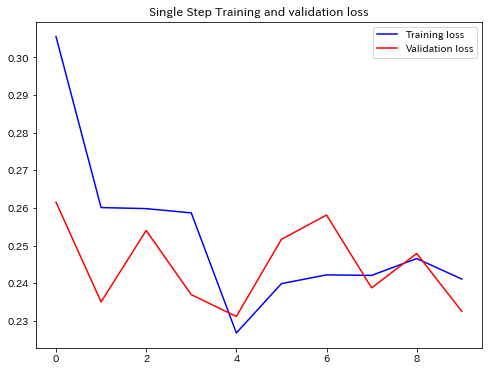

In [72]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

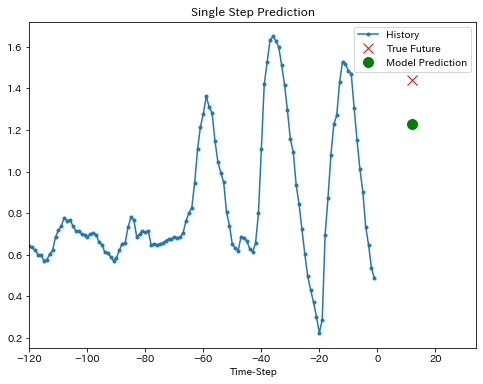

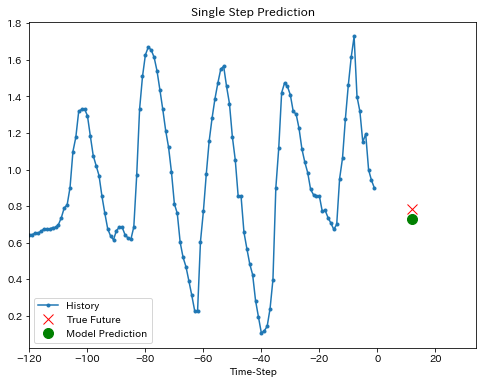

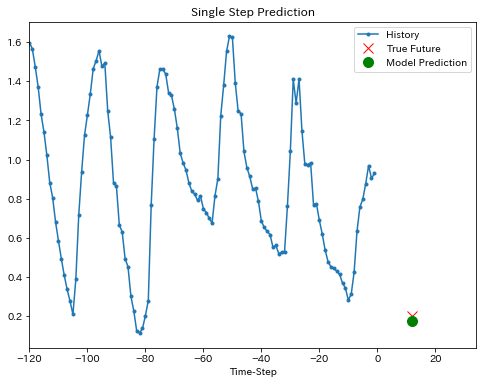

In [73]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),single_step_model.predict(x)[0]],
                     12,
                   'Single Step Prediction')
    plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict <u> a sequence of the future.</u>

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [75]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset,
                                                 dataset[:, 1],
                                                 0,
                                                 TRAIN_SPLIT, 
                                                 past_history,
                                                 future_target,
                                                 STEP)
x_val_multi, y_val_multi = multivariate_data(dataset,
                                             dataset[:, 1],
                                             TRAIN_SPLIT,
                                             None, 
                                             past_history,
                                             future_target,
                                             STEP)


In [83]:
print(x_train_multi.shape)
print(y_train_multi.shape)

(299280, 120, 3)
(299280, 72)


Let's check out a sample data-point.

In [86]:
print(x_train_multi[0])
print(y_train_multi[0])

[[ 0.95547359 -1.99766294  2.2350791 ]
 [ 0.95304508 -1.95134907  2.18442875]
 [ 0.96883036 -2.09376424  2.34176293]
 [ 0.99797241 -2.09260639  2.34812481]
 [ 1.01982895 -2.13776242  2.40317953]
 [ 1.06597053 -2.18870768  2.46997927]
 [ 1.11211211 -2.17944491  2.47218146]
 [ 1.1958955  -2.07755438  2.38482796]
 [ 1.28939291 -2.01155711  2.33858199]
 [ 1.35253402 -1.96176969  2.3026129 ]
 [ 1.43024615 -1.8830361   2.2389941 ]
 [ 1.47638773 -1.93513921  2.30750665]
 [ 1.40353261 -1.85293208  2.20033345]
 [ 1.37439056 -1.74409447  2.07921305]
 [ 1.35496252 -1.74525232  2.07407461]
 [ 1.37560481 -1.70935906  2.04128646]
 [ 1.38410457 -1.68388643  2.01632831]
 [ 1.3986756  -1.6977806   2.03565864]
 [ 1.39381859 -1.66651873  2.00164705]
 [ 1.41446088 -1.63641471  1.97448672]
 [ 1.41081812 -1.63988825  1.97815704]
 [ 1.4011041  -1.62946763  1.96323109]
 [ 1.3683193  -1.57968021  1.90254854]
 [ 1.35374827 -1.59010083  1.90964449]
 [ 1.32339197 -1.6016793   1.91282543]
 [ 1.29424992 -1.57736452

In [87]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [88]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [89]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

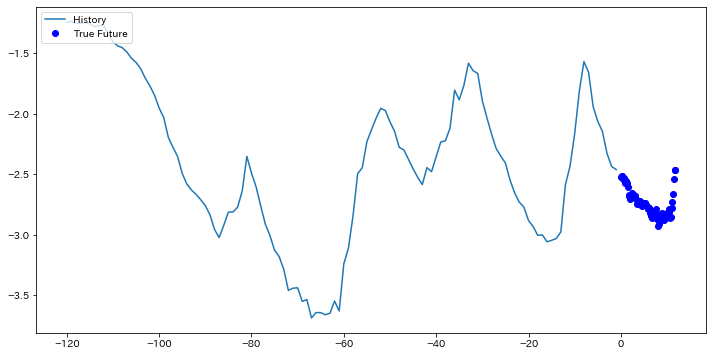

In [91]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [114]:
x_train_multi.shape

(299280, 120, 3)

In [ ]:
multi_step_model = tf.keras.models.Sequential()
#(timestep120, feature3)->(120,32)
#retuan seq:https://qiita.com/everylittle/items/b6f08891c1da41f30b24
#return stater :https://qiita.com/satelli/items/0f4810b698b6cebcbf93
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
#(120, 32)->(16)
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))#
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [112]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [113]:
multi_step_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 120, 32)           4608      
_________________________________________________________________
lstm_20 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_13 (Dense)             (None, 72)                1224      
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________


In [115]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 46s 230ms/step - loss: 0.4530 - val_loss: 0.3078
Epoch 2/10
200/200 [==============================] - 45s 224ms/step - loss: 0.3208 - val_loss: 0.2618
Epoch 3/10
200/200 [==============================] - 49s 246ms/step - loss: 0.2831 - val_loss: 0.2423
Epoch 4/10
200/200 [==============================] - 42s 211ms/step - loss: 0.2445 - val_loss: 0.2171
Epoch 5/10
200/200 [==============================] - 40s 201ms/step - loss: 0.2045 - val_loss: 0.2072
Epoch 6/10
200/200 [==============================] - 47s 234ms/step - loss: 0.2119 - val_loss: 0.2231
Epoch 7/10
200/200 [==============================] - 41s 205ms/step - loss: 0.2031 - val_loss: 0.2023
Epoch 8/10
200/200 [==============================] - 42s 212ms/step - loss: 0.1985 - val_loss: 0.2033
Epoch 9/10
200/200 [==============================] - 41s 203ms/step - loss: 0.2008 - val_loss: 0.1844
Epoch 10/10
200/200 [=========

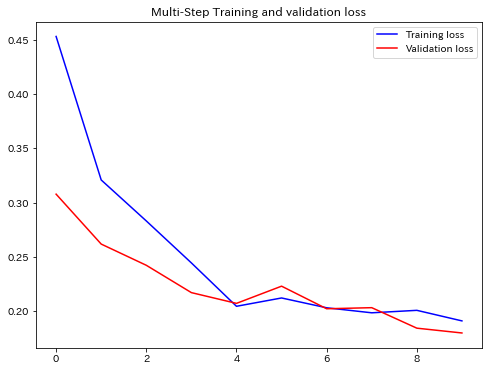

In [116]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

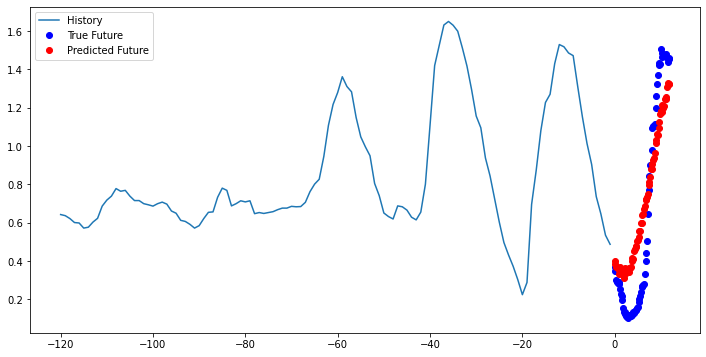

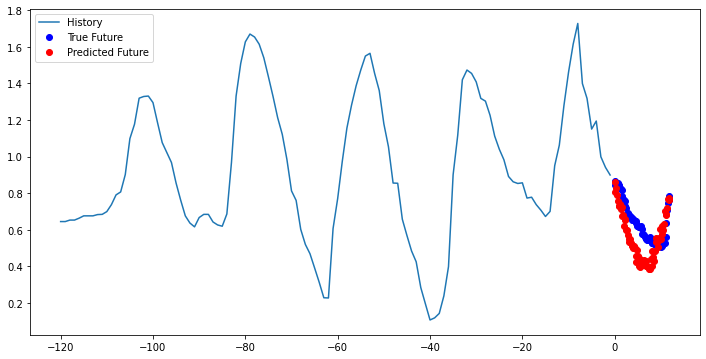

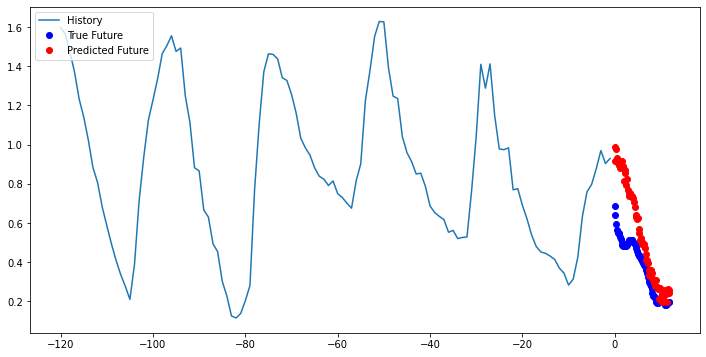

In [50]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## Next steps
This tutorial was a quick introduction to time series forecasting using an RNN. You may now try to predict the stock market and become a billionaire.

In addition, you may also write a generator to yield data (instead of the uni/multivariate_data function), which would be more memory efficient. You may also check out this [time series windowing](https://www.tensorflow.org/guide/data#time_series_windowing) guide and use it in this tutorial.

For further understanding, you may read Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition and Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).